In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydotplus
import seaborn as sns
import sklearn
import sys

from copy import deepcopy
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

RESULTS_PATH = os.path.join('./results')


# Getting the data & setup


In [2]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
# we probably wont use this until we know how to neural network
audio_df = pd.read_csv(DATA_PATH + 'audio_data.csv')
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')


In [4]:
song_dropped_df = song_dropped_df.drop(
    columns=['artist_name', 'track_name'])
song_filled_df = song_filled_df.drop(columns=['artist_name', 'track_name'])


In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i += 1

modes = dict({song_filled_df['mode'].unique()[0]: 0,
             song_filled_df['mode'].unique()[1]: 1})

song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])


In [6]:
# getting a list of all genre names
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

# getting a list of all features in each data frame
audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')


In [7]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']


creating the initial splits


In [8]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)


Separating data from labels


In [9]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))


1000
40560
50000


Some methods do not work with the string labels, so we mapped the genre titles for each data set to unique integers


In [10]:
y_audio_nums = y_audio.copy()
y_audio_nums.replace(audio_genres, [x for x in range(10)], inplace=True)

y_dropped_nums = y_dropped.copy()
y_dropped_nums.replace(dropped_genres, [x for x in range(10)], inplace=True)

y_filled_nums = y_filled.copy()
y_filled_nums.replace(filled_genres, [x for x in range(10)], inplace=True)


# Modeling


## Prepararation


In [11]:
audio_results_metrics = pd.DataFrame()
dropped_results_metrics = pd.DataFrame()
filled_results_metrics = pd.DataFrame()


In [12]:
# parameters:   pipe - model pipeline
#               params - dictionary of parameters specific to the model
#               X,y - X and y for the data set that should be used for cross validating
#               label - label of the data set
def run_grid_search(pipe, params, X, y, label, cv=None, n_jobs=-1):
    clf_GSCV = GridSearchCV(pipe, params, cv=cv)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

In [13]:
# defining the scaler we will be using
sc = StandardScaler()


## Training


### kNN Classifier


In [14]:
knn = KNeighborsClassifier()

knn_pipe = Pipeline(steps=[('sc', sc),
                           ('knn', knn)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

neighbor_counts = [15, 20, 25, 30, 40, 50]

parameters = dict(knn__n_neighbors=neighbor_counts)

knn_results_df = pd.DataFrame()
knn_results_df = knn_results_df.append(
    run_grid_search(knn_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
    run_grid_search(knn_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10)).append(
    run_grid_search(knn_pipe, parameters, X_filled, y_filled, 'Filled', cv=10))

knn_results_df.reset_index(inplace=True, drop=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1751291365.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_results_df = knn_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1751291365.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(knn_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1751291365.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(knn_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10)).append(


In [15]:
knn_results_df = knn_results_df.append(
    pd.DataFrame(run_grid_search(knn_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10))).append(pd.DataFrame(
    run_grid_search(knn_pipe, parameters, X_filled, y_filled, 'Filled', cv=10)))

knn_results_df.reset_index(inplace=True, drop=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\2042832201.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_results_df = knn_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\2042832201.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame(run_grid_search(knn_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10))).append(pd.DataFrame(


In [16]:
best_knn_audio = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                (knn_results_df.label == 'Audio')]

best_knn_dropped = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                  (knn_results_df.label == 'Dropped')]

best_knn_filled = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                 (knn_results_df.label == 'Filled')]


In [17]:
print('best audio parameters:\n', '--n_neighbors--\n',
      best_knn_audio.param_knn__n_neighbors.values)

print('\n\nbest dropped parameters:\n', '--n_neighbors--\n',
      best_knn_dropped.param_knn__n_neighbors.values)

print('\n\nbest filled parameters:\n', '--n_neighbors--\n',
      best_knn_filled.param_knn__n_neighbors.values)


best audio parameters:
 --n_neighbors--
 [15]


best dropped parameters:
 --n_neighbors--
 [30 30]


best filled parameters:
 --n_neighbors--
 [40 40]


In [18]:
knn_pipe = Pipeline(steps=[('knn', knn)])
knn_audio = deepcopy(knn_pipe)
knn_audio.set_params(**best_knn_audio.params.values[0])
knn_audio.fit(X_audio_train, y_audio_train)
y_pred_knn_audio = knn_audio.predict(X_audio_test)

knn_dropped = deepcopy(knn_pipe)
knn_dropped.set_params(**best_knn_dropped.params.values[0])
knn_dropped.fit(X_dropped_train, y_dropped_train)
y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)

knn_filled = deepcopy(knn_pipe)
knn_filled.set_params(**best_knn_filled.params.values[0])
knn_filled.fit(X_filled_train, y_filled_train)
y_pred_knn_filled = knn_filled.predict(X_filled_test)


In [19]:
knn_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_knn_audio, output_dict=True))
knn_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_knn_dropped, output_dict=True))
knn_result_metrics_filled = pd.DataFrame(classification_report(
    y_filled_test, y_pred_knn_filled, output_dict=True))

knn_result_metrics_audio['model_type'] = 'knn'
knn_result_metrics_dropped['model_type'] = 'knn'
knn_result_metrics_filled['model_type'] = 'knn'

audio_results_metrics = knn_result_metrics_audio
dropped_results_metrics = knn_result_metrics_dropped
filled_results_metrics = knn_result_metrics_filled

print('Accuracy for audio: {:.3f}'.format(
    knn_result_metrics_audio['accuracy'].iloc[0]))
print('Accuracy for dropped: {:.3f}'.format(
    knn_result_metrics_dropped['accuracy'].iloc[0]))
print('Accuracy for filled: {:.3f}'.format(
    knn_result_metrics_filled['accuracy'].iloc[0]))


Accuracy for audio: 0.400
Accuracy for dropped: 0.442
Accuracy for filled: 0.451


### Logistic Regression


In [20]:
sc = StandardScaler()
logreg = LogisticRegression()

logreg_pipe = Pipeline(steps=[('sc', sc),
                              ('logreg', logreg)])

solvers = ['lbfgs', 'liblinear', 'newton-cg']

max_iters = [100, 1000, 10000]

parameters = dict(logreg__solver=solvers, logreg__max_iter=max_iters)

logreg_results_df = pd.DataFrame()
logreg_results_df = logreg_results_df.append(
    run_grid_search(logreg_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
    run_grid_search(logreg_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10)).append(
    run_grid_search(logreg_pipe, parameters, X_filled, y_filled, 'Filled', cv=10))

logreg_results_df.reset_index(inplace=True, drop=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\495497455.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  logreg_results_df = logreg_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\495497455.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(logreg_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\495497455.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(logreg_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10)).append(


In [21]:
best_logreg_audio = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                      (logreg_results_df.label == 'Audio')]

best_logreg_dropped = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                        (logreg_results_df.label == 'Dropped')]

best_logreg_filled = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                       (logreg_results_df.label == 'Filled')]


In [22]:
print('\nbest audio parameters:\n', '--max_iter--\n', best_logreg_audio.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_audio.param_logreg__solver.values[0])

print('\n\nbest dropped parameters:\n', '--max_iter--\n', best_logreg_dropped.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_dropped.param_logreg__solver.values[0])

print('\n\nbest filled parameters:\n', '--max_iter--\n', best_logreg_filled.param_logreg__max_iter.values,
      '\n--solver--\n', best_logreg_filled.param_logreg__solver.values[0])



best audio parameters:
 --max_iter--
 [100 100 1000 1000 10000 10000] 
--solver--
 lbfgs


best dropped parameters:
 --max_iter--
 [100 100 1000 1000 10000 10000] 
--solver--
 lbfgs


best filled parameters:
 --max_iter--
 [100 1000 10000] 
--solver--
 lbfgs


In [23]:
logreg_audio = deepcopy(logreg_pipe)
logreg_audio.set_params(**best_logreg_audio.params.values[0])
logreg_audio.fit(X_audio_train, y_audio_train)
y_pred_logreg_audio = logreg_audio.predict(X_audio_test)

logreg_dropped = deepcopy(logreg_pipe)
logreg_dropped.set_params(**best_logreg_dropped.params.values[0])
logreg_dropped.fit(X_dropped_train, y_dropped_train)
y_pred_logreg_dropped = logreg_dropped.predict(X_dropped_test)

logreg_filled = deepcopy(logreg_pipe)
logreg_filled.set_params(**best_logreg_filled.params.values[0])
logreg_filled.fit(X_filled_train, y_filled_train)
y_pred_logreg_filled = logreg_filled.predict(X_filled_test)


In [24]:
logreg_result_metrics_audio = pd.DataFrame(classification_report(y_audio_test, y_pred_logreg_audio,
                                                                 output_dict=True))
logreg_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_logreg_dropped,
    output_dict=True))
logreg_result_metrics_filled = pd.DataFrame(classification_report(y_filled_test, y_pred_logreg_filled,
                                                                  output_dict=True))

logreg_result_metrics_audio['model_type'] = 'logreg'
logreg_result_metrics_dropped['model_type'] = 'logreg'
logreg_result_metrics_filled['model_type'] = 'logreg'

audio_results_metrics = audio_results_metrics.append(
    logreg_result_metrics_audio)
dropped_results_metrics = dropped_results_metrics.append(
    logreg_result_metrics_dropped)
filled_results_metrics = filled_results_metrics.append(
    logreg_result_metrics_filled)

print('Accuracy for audio: {:.3f}'.format(
    logreg_result_metrics_audio['accuracy'].iloc[0]))
print('Accuracy for dropped: {:.3f}'.format(
    logreg_result_metrics_dropped['accuracy'].iloc[0]))
print('Accuracy for filled: {:.3f}'.format(
    logreg_result_metrics_filled['accuracy'].iloc[0]))


Accuracy for audio: 0.400
Accuracy for dropped: 0.525
Accuracy for filled: 0.528


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1693757163.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_results_metrics = audio_results_metrics.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1693757163.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dropped_results_metrics = dropped_results_metrics.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1693757163.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_results_metrics = filled_results_metrics.append(


### Decision Trees


In [25]:
# creating a pipeline for the decision tree models
tree = DecisionTreeClassifier()

tree_pipe = Pipeline(steps=[
    ('tree', tree)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

criterion = ['gini', 'entropy']
max_depth = [4, 6, 8, 10]

parameters = dict(
    tree__criterion=criterion,
    tree__max_depth=max_depth)

tree_results_df = pd.DataFrame()
tree_results_df = tree_results_df.append(
    run_grid_search(tree_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
    run_grid_search(tree_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10)).append(
    run_grid_search(tree_pipe, parameters, X_filled, y_filled, 'Filled', cv=10))

tree_results_df.reset_index(inplace=True, drop=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1062201408.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tree_results_df = tree_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1062201408.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(tree_pipe, parameters, X_audio, y_audio, 'Audio', cv=3)).append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\1062201408.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(tree_pipe, parameters, X_dropped, y_dropped, 'Dropped', cv=10)).append(


In [26]:
best_tree_audio = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                  (tree_results_df.label == 'Audio')]

best_tree_dropped = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                    (tree_results_df.label == 'Dropped')]

best_tree_filled = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                   (tree_results_df.label == 'Filled')]

In [27]:
print('best audio parameters:\n', '--criterion--\n',
      best_tree_audio.param_tree__criterion.values, '\n--max_depth--\n',
      best_tree_audio.param_tree__max_depth.values)

print('\n\nbest dropped parameters:\n', '--criterion--\n',
      best_tree_dropped.param_tree__criterion.values, '\n--max_depth--\n',
      best_tree_dropped.param_tree__max_depth.values)

print('\n\nbest filled parameters:\n', '--criterion--\n',
      best_tree_filled.param_tree__criterion.values, '\n--max_depth--\n',
      best_tree_filled.param_tree__max_depth.values)


best audio parameters:
 --criterion--
 ['gini'] 
--max_depth--
 [6]


best dropped parameters:
 --criterion--
 ['entropy'] 
--max_depth--
 [10]


best filled parameters:
 --criterion--
 ['gini'] 
--max_depth--
 [10]


In [28]:
tree_audio = deepcopy(tree_pipe)
tree_audio.set_params(**best_tree_audio.params.values[0])
tree_audio.fit(X_audio_train, y_audio_train)
y_pred_tree_audio = tree_audio.predict(X_audio_test)

tree_dropped = deepcopy(tree_pipe)
tree_dropped.set_params(**best_tree_dropped.params.values[0])
tree_dropped.fit(X_dropped_train, y_dropped_train)
y_pred_tree_dropped = tree_dropped.predict(X_dropped_test)

tree_filled = deepcopy(tree_pipe)
tree_filled.set_params(**best_tree_filled.params.values[0])
tree_filled.fit(X_filled_train, y_filled_train)
y_pred_tree_filled = tree_filled.predict(X_filled_test)


In [29]:
tree_audio.feature_names_in_

array(['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid',
       'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies'],
      dtype=object)

In [30]:
tree_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_tree_audio, output_dict=True))
tree_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_tree_dropped, output_dict=True))
tree_result_metrics_filled = pd.DataFrame(classification_report(
    y_filled_test, y_pred_tree_filled, output_dict=True))

tree_result_metrics_audio['model_type'] = 'tree'
tree_result_metrics_dropped['model_type'] = 'tree'
tree_result_metrics_filled['model_type'] = 'tree'

audio_results_metrics = audio_results_metrics.append(
    tree_result_metrics_audio)
dropped_results_metrics = dropped_results_metrics.append(
    tree_result_metrics_dropped)
filled_results_metrics = filled_results_metrics.append(
    tree_result_metrics_filled)

print('Accuracy for audio: {:.3f}'.format(
    tree_result_metrics_audio['accuracy'].iloc[0]))
print('Accuracy for dropped: {:.3f}'.format(
    tree_result_metrics_dropped['accuracy'].iloc[0]))
print('Accuracy for filled: {:.3f}'.format(
    tree_result_metrics_filled['accuracy'].iloc[0]))


Accuracy for audio: 0.370
Accuracy for dropped: 0.517
Accuracy for filled: 0.529


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\427987434.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_results_metrics = audio_results_metrics.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\427987434.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dropped_results_metrics = dropped_results_metrics.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\427987434.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_results_metrics = filled_results_metrics.append(


### Random Forest


In [31]:
forest = RandomForestClassifier()

forest_pipe = Pipeline(steps=[('sc', sc),
                              ('forest', forest)])

n_estimators = [10, 50, 100, 200]
# We determined entropy was optimal from the decision tree modeling
criterion = ['entropy']
# We determined 10 was optimal from the decision tree modeling
max_depth = [10]

forest_parameters = dict(forest__n_estimators=n_estimators,
                         forest__criterion=criterion,
                         forest__max_depth=max_depth)

forest_results_df = pd.DataFrame()
forest_results_df = forest_results_df.append(
    run_grid_search(forest_pipe, forest_parameters, X_audio, y_audio, 'Audio')).append(
    run_grid_search(forest_pipe, forest_parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_grid_search(forest_pipe, forest_parameters, X_filled, y_filled, 'Filled'))

forest_results_df.reset_index(inplace=True, drop=True)


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\2330033481.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forest_results_df = forest_results_df.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\2330033481.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(forest_pipe, forest_parameters, X_audio, y_audio, 'Audio')).append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\2330033481.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  run_grid_search(forest_pipe, forest_parameters, X_dropped, y_dropped, 'Dropped')).append(


In [32]:
best_forest_audio = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                      (forest_results_df.label == 'Audio')]

best_forest_dropped = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                        (forest_results_df.label == 'Dropped')]

best_forest_filled = forest_results_df[(forest_results_df.rank_test_score == 1) &
                                       (forest_results_df.label == 'Filled')]


In [33]:
print('best audio parameters:\n', '--n_estimators--\n',
      best_forest_audio.param_forest__n_estimators.values)
print('\n\nbest dropped parameters:\n', '--n_estimators--\n',
      best_forest_dropped.param_forest__n_estimators.values)
print('\n\nbest filled parameters:\n', '--n_estimators--\n',
      best_forest_filled.param_forest__n_estimators.values)


best audio parameters:
 --n_estimators--
 [50 200]


best dropped parameters:
 --n_estimators--
 [200]


best filled parameters:
 --n_estimators--
 [100]


In [34]:
forest_audio = deepcopy(forest_pipe)
forest_audio.set_params(**best_forest_audio.params.values[0])
forest_audio.fit(X_audio_train, y_audio_train)
y_pred_forest_audio = forest_audio.predict(X_audio_test)

forest_dropped = deepcopy(forest_pipe)
forest_dropped.set_params(**best_forest_dropped.params.values[0])
forest_dropped.fit(X_dropped_train, y_dropped_train)
y_pred_forest_dropped = forest_dropped.predict(X_dropped_test)

forest_filled = deepcopy(forest_pipe)
forest_filled.set_params(**best_forest_filled.params.values[0])
forest_filled.fit(X_filled_train, y_filled_train)
y_pred_forest_filled = forest_filled.predict(X_filled_test)


In [35]:
forest_result_metrics_audio = pd.DataFrame(classification_report(
    y_audio_test, y_pred_forest_audio, output_dict=True))
forest_result_metrics_dropped = pd.DataFrame(classification_report(
    y_dropped_test, y_pred_forest_dropped, output_dict=True))
forest_result_metrics_filled = pd.DataFrame(classification_report(
    y_filled_test, y_pred_forest_filled, output_dict=True))

forest_result_metrics_audio['model_type'] = 'forest'
forest_result_metrics_dropped['model_type'] = 'forest'
forest_result_metrics_filled['model_type'] = 'forest'

audio_results_metrics = audio_results_metrics.append(
    forest_result_metrics_audio)
dropped_results_metrics = dropped_results_metrics.append(
    forest_result_metrics_dropped)
filled_results_metrics = filled_results_metrics.append(
    forest_result_metrics_filled)

print('Accuracy for audio: {:.3f}'.format(
    forest_result_metrics_audio['accuracy'].iloc[0]))
print('Accuracy for dropped: {:.3f}'.format(
    forest_result_metrics_dropped['accuracy'].iloc[0]))
print('Accuracy for filled: {:.3f}'.format(
    forest_result_metrics_filled['accuracy'].iloc[0]))


Accuracy for audio: 0.460
Accuracy for dropped: 0.571
Accuracy for filled: 0.593


C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\346108325.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audio_results_metrics = audio_results_metrics.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\346108325.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dropped_results_metrics = dropped_results_metrics.append(
C:\Users\alexs\AppData\Local\Temp\ipykernel_19268\346108325.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_results_metrics = filled_results_metrics.append(


## Plotting the Results


#### Result metrics data


In [36]:
def plot_metrics_by_genre(results_df, genres, title='Boxplots for each genre', plot_name=None):
    df = results_df.drop(
        columns=['macro avg', 'weighted avg'], index='support').reset_index()
    df = df.melt(id_vars=['model_type', 'index'], value_vars=genres)
    df = df.rename(columns={'index': 'metrics',
                            'variable': 'genres', 'value': 'score'})
    metrics = df.metrics.unique()
    ncols = 5
    nrows = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10), sharey=True)
    i = 0
    for genre in genres:
        temp = df[df.genres == genre]
        idx = (int(i / ncols), int(i % ncols))
        axs[idx].boxplot([temp[metrics[j] ==
                                     temp.metrics]['score'] for j in range(
            3)], labels=[metrics[j] for j in range(3)])
        axs[idx].set(title=temp.genres.any(), ylim = (0,1) )
        i += 1

    fig.suptitle(title, size='xx-large')

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'genre_boxplots_' + plot_name + '.png'))
    plt.show()


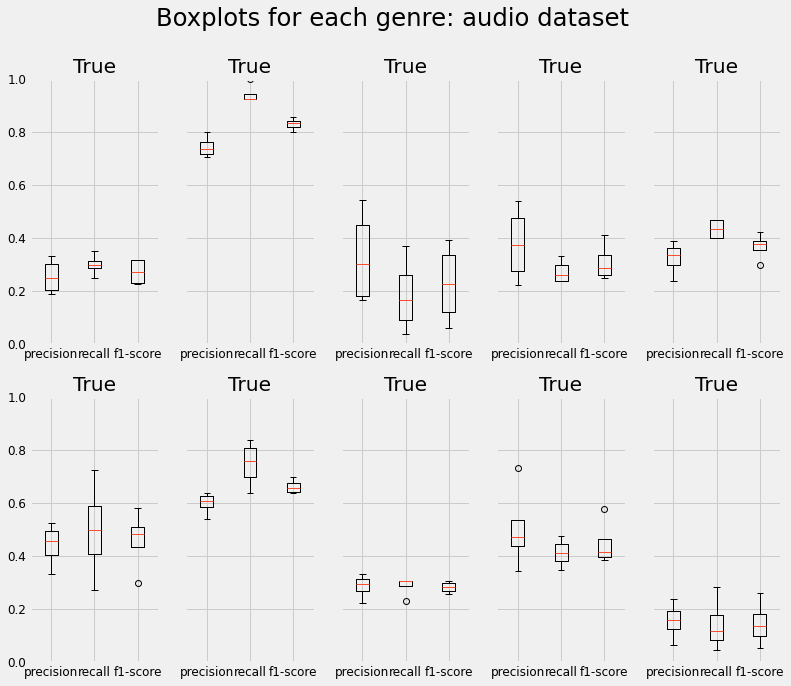

In [37]:
plot_metrics_by_genre(audio_results_metrics, audio_genres,
                      'Boxplots for each genre: audio dataset', 'audio')


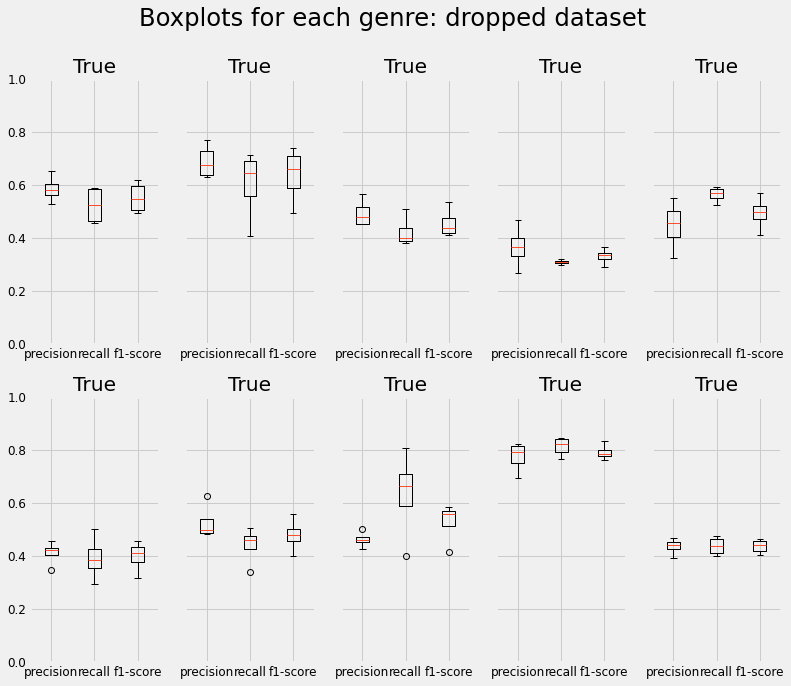

In [38]:
plot_metrics_by_genre(dropped_results_metrics, dropped_genres,
                      'Boxplots for each genre: dropped dataset', 'dropped')


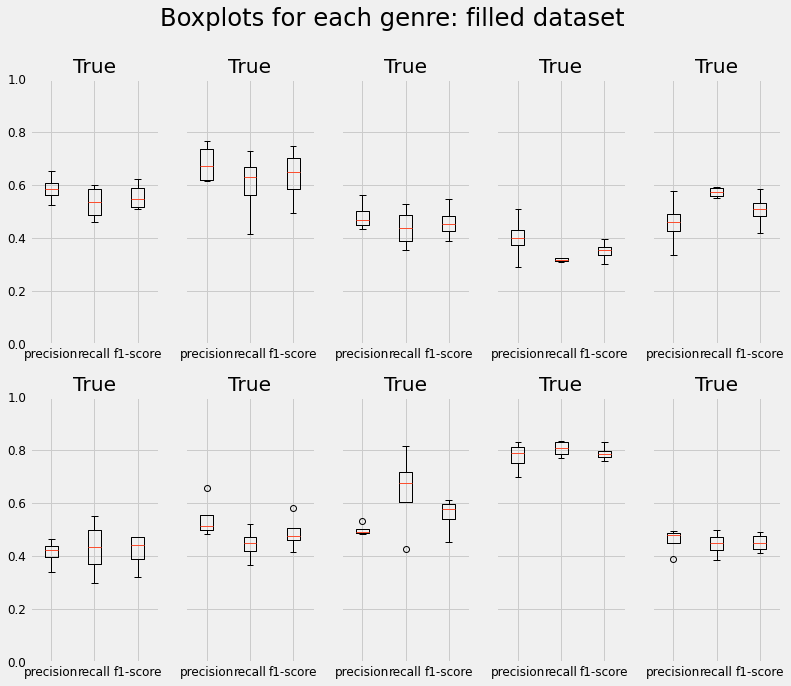

In [39]:
plot_metrics_by_genre(filled_results_metrics, filled_genres,
                      'Boxplots for each genre: filled dataset', 'filled')


In [40]:
import seaborn as sns

def plot_metrics_by_model(results_df, genres, title='Boxplots for each genre', plot_name=None):
    df = results_df.drop(
        columns=['macro avg', 'weighted avg'], index='support').reset_index()
    df = df.melt(id_vars=['model_type', 'index'], value_vars=genres)
    df = df.rename(columns={'index': 'metrics',
                            'variable': 'genres', 'value': 'score'})
    models = df.model_type.unique()
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    i = 0
    for metric in df.metrics.unique():
        temp = df[df.metrics == metric]
        idx = i
        axs[idx].boxplot([temp[models[j] == temp.model_type]['score'] for j in range(
            4)], labels=[models[j] for j in range(4)])
        axs[idx].set(title=temp.metrics.any(), ylim = (0,1))
        # axs[idx].set_xticks([binw[i*4] for i in range(5)])
        i += 1

    fig.suptitle(title, size='xx-large')
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.9,
        top=0.8)
    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'metric_boxplots_' + plot_name + '.png'))
    plt.show()


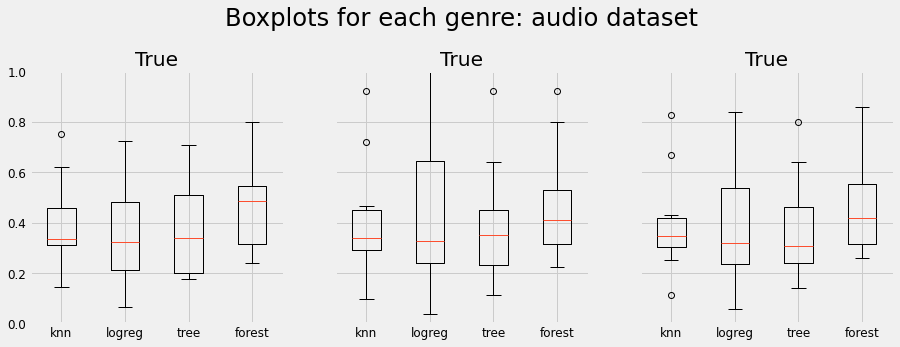

In [41]:
plot_metrics_by_model(audio_results_metrics, audio_genres,
                      'Boxplots for each genre: audio dataset', 'audio')


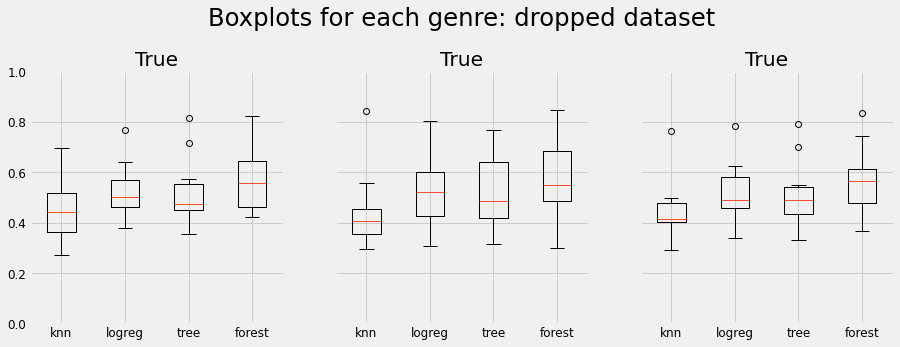

In [42]:
plot_metrics_by_model(dropped_results_metrics, dropped_genres,
                      'Boxplots for each genre: dropped dataset', 'dropped')


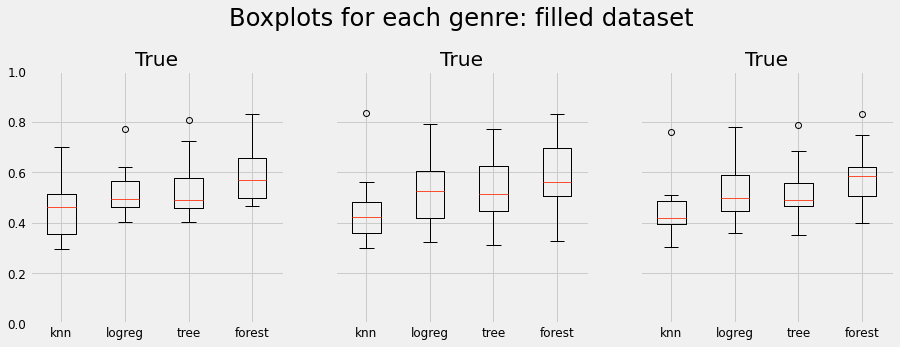

In [43]:
plot_metrics_by_model(filled_results_metrics, filled_genres,
                      'Boxplots for each genre: filled dataset', 'filled')


#### Writing results data frames to .csv files


In [44]:
knn_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'knn_results.csv'),
    index=False)

tree_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'tree_results.csv'),
    index=False)

logreg_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'logreg_results.csv'),
    index=False)

forest_results_df.to_csv(
    os.path.join(RESULTS_PATH, 'forest_results.csv'),
    index=False)

audio_results_metrics.to_csv(
    os.path.join(RESULTS_PATH, 'audio_results_metrics.csv'),
    index=False)

dropped_results_metrics.to_csv(
    os.path.join(RESULTS_PATH, 'dropped_results_metrics.csv'),
    index=False)

filled_results_metrics.to_csv(
    os.path.join(RESULTS_PATH, 'filled_results_metrics.csv'),
    index=False)


#### Confusion Matrices


In [45]:
from sklearn.metrics import confusion_matrix

def plot_confustion_matrices(preds, tests, plot_name):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    
    
    for i in range(3):
        confusion_mat = confusion_matrix(tests[i], preds[i])
        sns.heatmap(confusion_mat, annot=True, cmap='magma', ax=axs[i], fmt='g')

    axs[0].set(title='Audio')
    axs[1].set(title='Dropped')
    axs[2].set(title='Filled')

    for i in range(3):
        axs[i].grid(False)

    axs[0].set_xticklabels(
        [audio_genres[i] for i in range(10)],
        rotation=45,
        horizontalalignment='right'
    )
    axs[0].set_yticklabels(
        [audio_genres[i] for i in range(10)],
        rotation=0,
        horizontalalignment='right'
    )

    axs[1].set_xticklabels(
        [dropped_genres[i] for i in range(10)],
        rotation=45,
        horizontalalignment='right'
    )
    axs[1].set_yticklabels(
        [dropped_genres[i] for i in range(10)],
        rotation=0,
        horizontalalignment='right'
    )

    axs[2].set_xticklabels(
        [filled_genres[i] for i in range(10)],
        rotation=45,
        horizontalalignment='right'
    )
    axs[2].set_yticklabels(
        [filled_genres[i] for i in range(10)],
        rotation=0,
        horizontalalignment='right'
    )

    plt.suptitle(
        f'Confusion matrices for {plot_name} models with optimal paramters',
        fontsize=16)

    plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=0.9,
        top=0.8,
        wspace=0.2,
        hspace=0.4)

    # plt.subplots_adjust(left=0.1,
    #                     bottom=0.2,
    #                     right=0.8,
    #                     top=0.9,
    #                     wspace=0.3,
    #                     hspace=0.1)
    
    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'confusion_matrices_' + plot_name + '.png'))


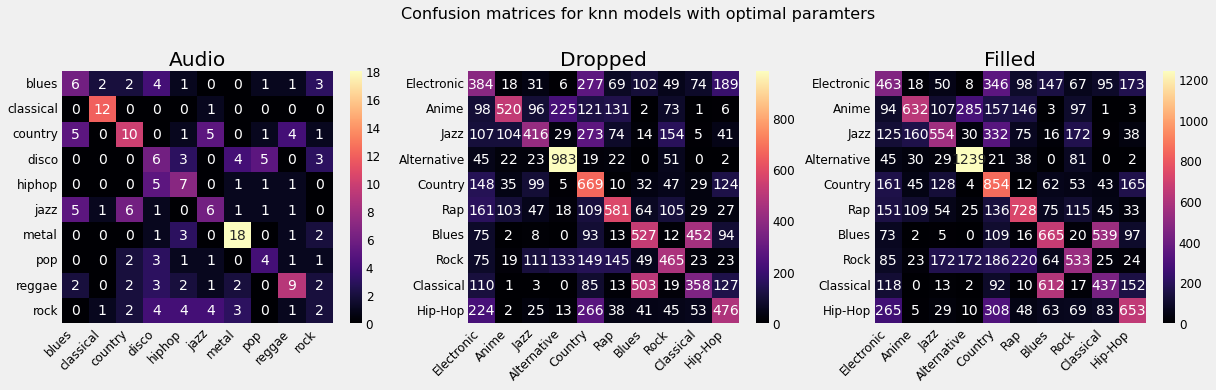

In [46]:
plot_confustion_matrices([y_pred_knn_audio, y_pred_knn_dropped, y_pred_knn_filled], [y_audio_test, y_dropped_test, y_filled_test],'knn')

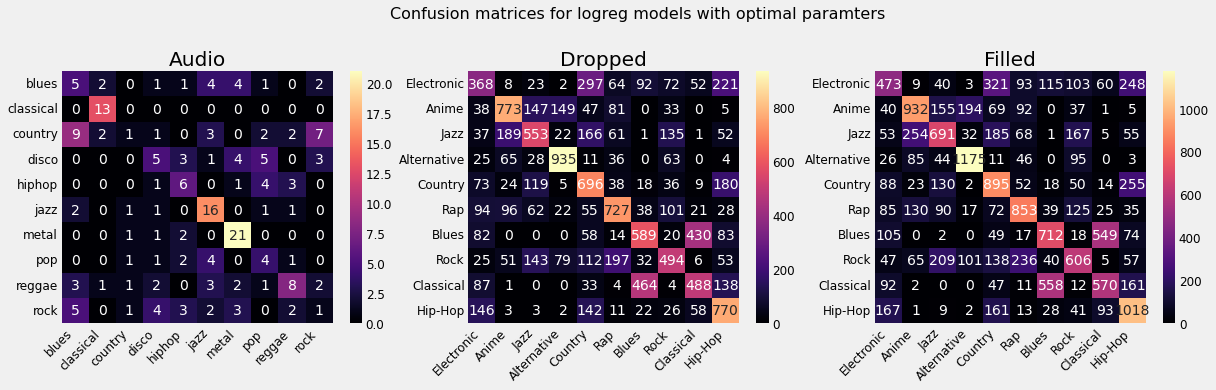

In [47]:
plot_confustion_matrices(
    [y_pred_logreg_audio, y_pred_logreg_dropped, y_pred_logreg_filled], [y_audio_test, y_dropped_test, y_filled_test], 'logreg')


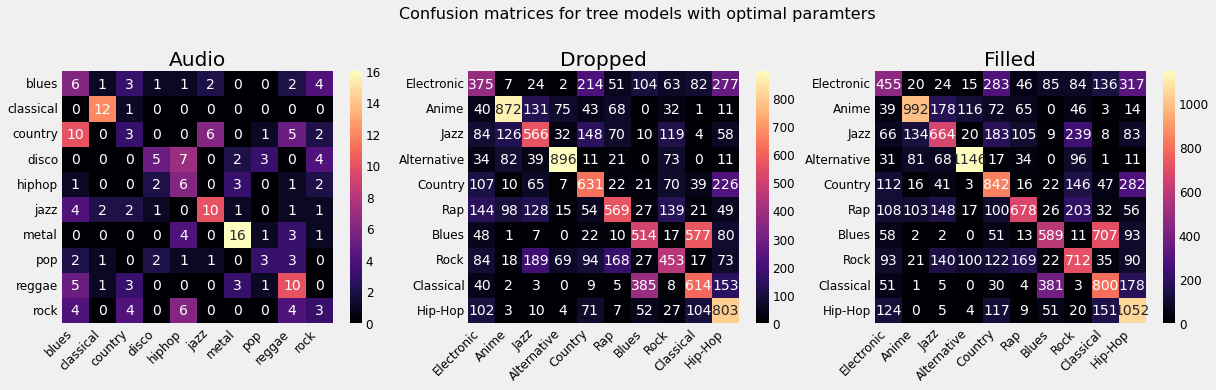

In [48]:
plot_confustion_matrices([y_pred_tree_audio, y_pred_tree_dropped, y_pred_tree_filled], [
                         y_audio_test, y_dropped_test, y_filled_test], 'tree')

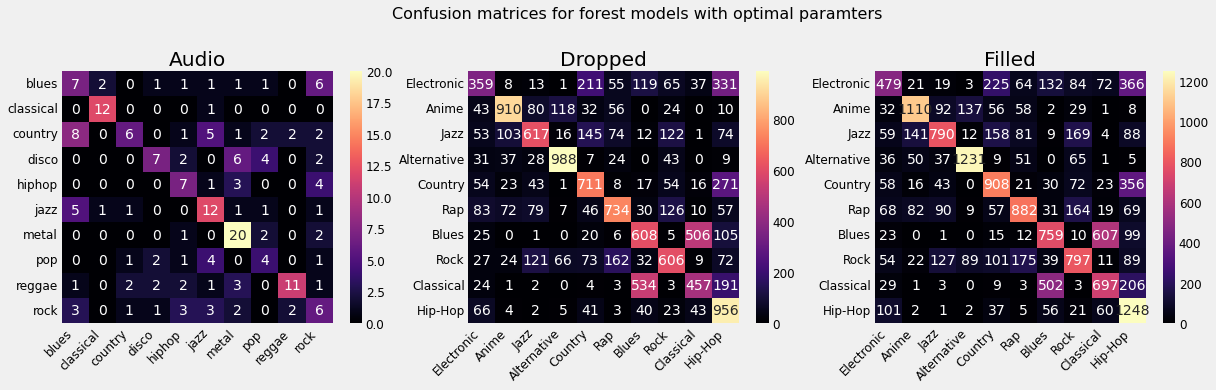

In [49]:
plot_confustion_matrices(
    [y_pred_forest_audio, y_pred_forest_dropped, y_pred_forest_filled], [y_audio_test, y_dropped_test, y_filled_test], 'forest')


#### Decision Tree Diagrams


In [50]:
dot_data = export_graphviz(
    tree_audio.named_steps['tree'],
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(RESULTS_PATH, "audio_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
# Source(pydot_graph.to_string())


True

In [51]:
dot_data = export_graphviz(
    tree_dropped.named_steps['tree'],
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(RESULTS_PATH, "dropped_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
# Source(pydot_graph.to_string())


True

In [52]:
dot_data = export_graphviz(
    tree_filled.named_steps['tree'],
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(RESULTS_PATH, "filled_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
# Source(pydot_graph.to_string())

True

#### Learning Curves


In [53]:
def plot_learning_curve(model, X, y, title=None, plot_name=None, splits=15):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True)
    train_sizes = np.linspace(0.05, 0.8, splits)
    train_sizes, train_mse, test_mse = learning_curve(model, X, y,
                                                      train_sizes=train_sizes,
                                                      scoring='neg_root_mean_squared_error',
                                                      cv=5, shuffle=True)

    train_scores = np.sqrt(np.abs(train_mse))
    test_scores = np.sqrt(np.abs(test_mse))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.set_title(f'test split size', fontsize=14)
    ax.plot(train_sizes, train_scores_mean, 'o-',
            color="r", label="Training score", linewidth=1, markersize=2)
    ax.plot(train_sizes, test_scores_mean, 'o-',
            color="b", label="Cross-validation score", linewidth=1, markersize=2)
    ax.set_xlabel("Training set size", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.legend(loc="best", fontsize=12)

    fig.suptitle(title, fontsize=16)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curve_' + plot_name + '.png'))

In [54]:
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
def plot_learning_curves(model, X, y, title=None, splits=[.05, .1, .15, .2, .25, .3, .35, .4], start_size=5, plot_name=None, scale=10):
    nrows = int(np.sqrt(len(splits)))
    ncols = int((len(splits) + 1) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 8), sharey=True)
    i = 0
    X_scaled = X.copy()
    sc.fit(X,y)
    X_scaled = sc.transform(X_scaled)
    miny = 10
    for split in splits:
        if nrows == 1:
            idx = i
        else:
            idx = (int(i / ncols), int(i % ncols))

        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y, test_size=split)
        train_errors, val_errors, xs = [], [], []

        for m in range(start_size, len(X_train), scale):
            model.fit(X_train[:m], y_train[:m])
            y_train_predict = model.predict(X_train[:m])
            y_val_predict = model.predict(X_val)
            train_errors.append(mean_squared_error(
                y_train[:m], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))
            xs.append(m)
        
        axs[idx].set_title(f'test split size: {split}', fontsize=14)
        axs[idx].plot(xs, np.sqrt(train_errors), 'r--.',
                      linewidth=0.5, label="train", markersize=3)
        axs[idx].plot(xs, np.sqrt(val_errors), "b-", linewidth=2, label="test")
        axs[idx].legend(loc="upper right", fontsize=12)
        axs[idx].set_xlabel("Training set size", fontsize=12)
        axs[idx].set_ylabel("RMSE", fontsize=12)
        miny = min(min([train_errors.pop(0)]), miny)
        axs[idx].set_xlim(xs[0], xs[-1])
        i += 1
        
    axs[idx].set_ylim(np.sqrt(miny), max(np.sqrt(val_errors)))
        
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.4)

    if plot_name:
        plt.savefig(os.path.join(
            RESULTS_PATH, 'learning_curves_' + plot_name + '.png'))


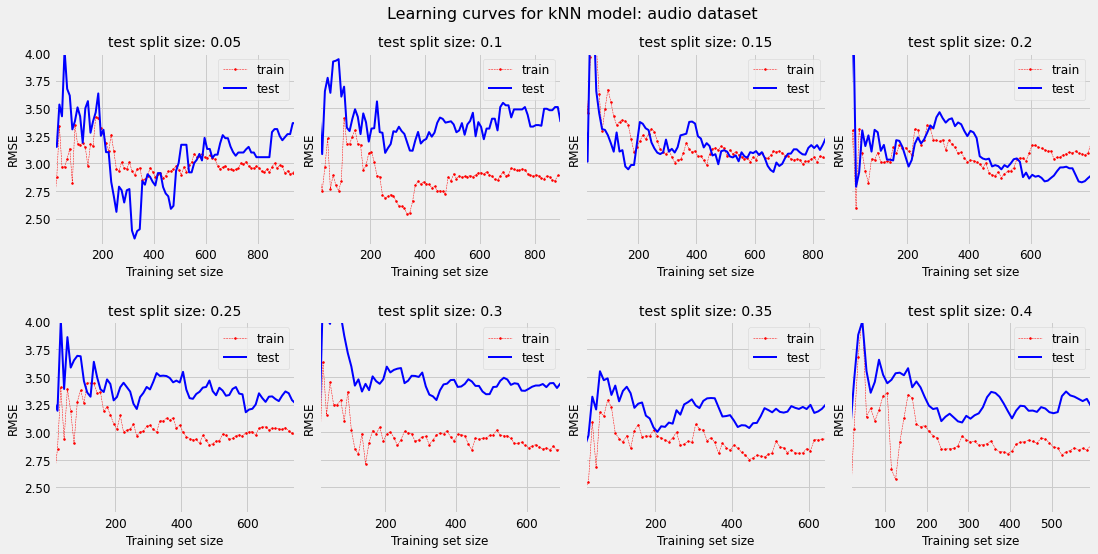

In [55]:
plot_learning_curves(knn_audio, X_audio, y_audio_nums,
                     'Learning curves for kNN model: audio dataset', plot_name='knn_audio', start_size=best_knn_audio['param_knn__n_neighbors'].values[0])

# plot_learning_curve(knn_audio, X_audio, y_audio_nums,'Learning curves for kNN model: audio dataset', plot_name='knn_audio', splits = 30)


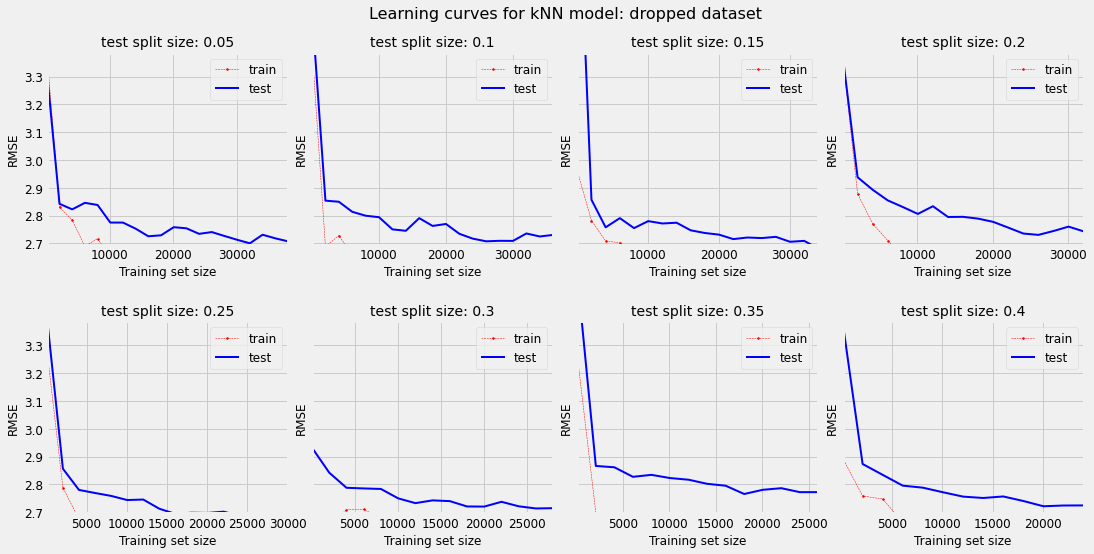

In [56]:
plot_learning_curves(knn_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped', start_size=best_knn_dropped['param_knn__n_neighbors'].values[0] * 2, scale=2000)

# plot_learning_curve(knn_dropped, X_dropped, y_dropped_nums,'Learning curves for kNN model: dropped dataset', plot_name='knn_dropped')


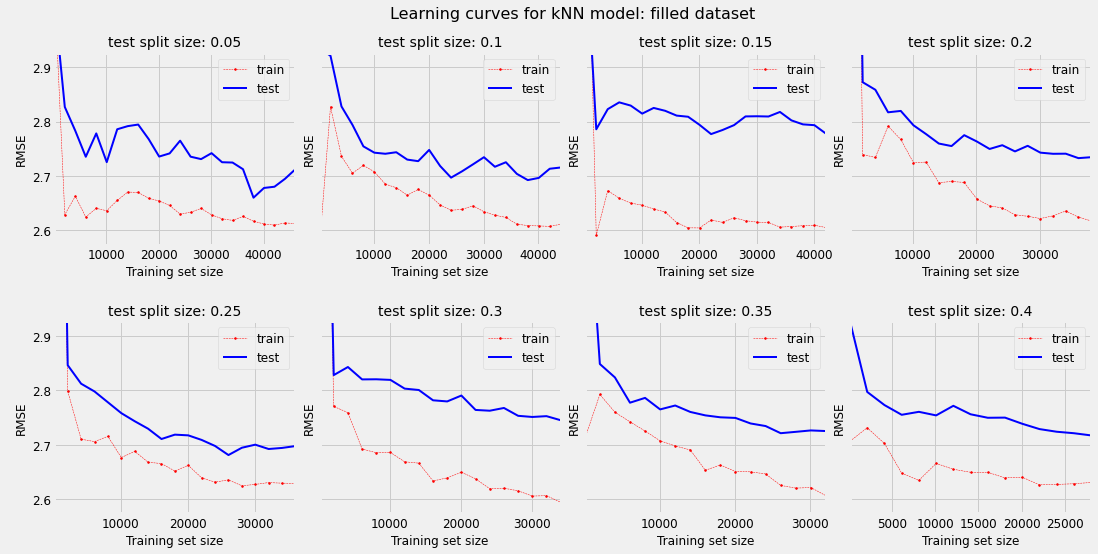

In [57]:
plot_learning_curves(knn_filled, X_filled, y_filled_nums, 'Learning curves for kNN model: filled dataset',
                     plot_name='knn_filled', start_size=best_knn_filled['param_knn__n_neighbors'].values[0] * 2, scale=2000)

# plot_learning_curve(knn_filled, X_filled, y_filled_nums,
#                      'Learning curves for kNN model: filled dataset', plot_name='knn_filled')


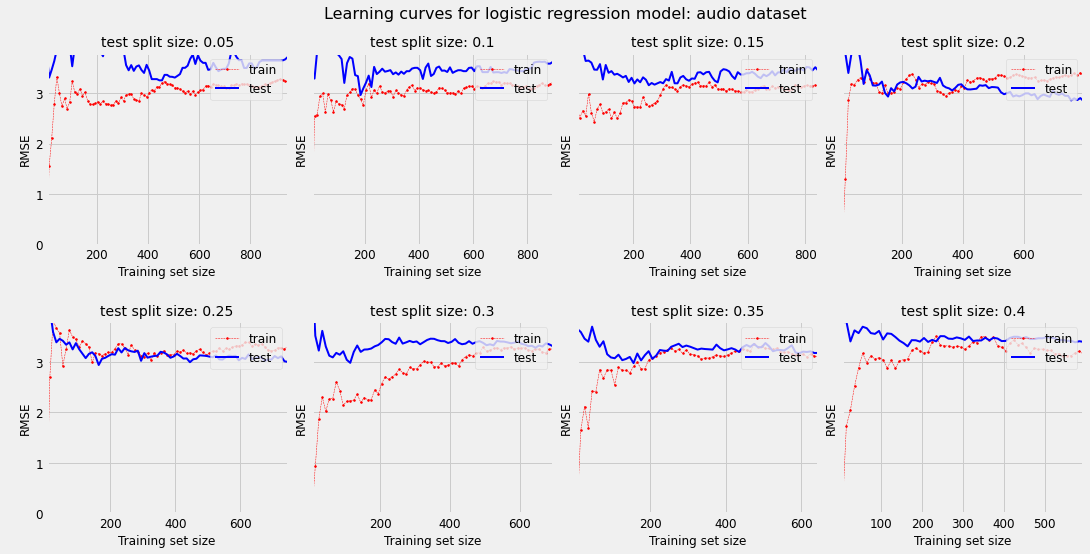

In [58]:
plot_learning_curves(logreg_audio, X_audio, y_audio_nums,
                     'Learning curves for logistic regression model: audio dataset', plot_name='logreg_audio', start_size=5)

# plot_learning_curve(logreg_audio, X_audio, y_audio_nums,
#                      'Learning curves for logistic regression model: audio dataset', plot_name='logreg_audio', splits=50)


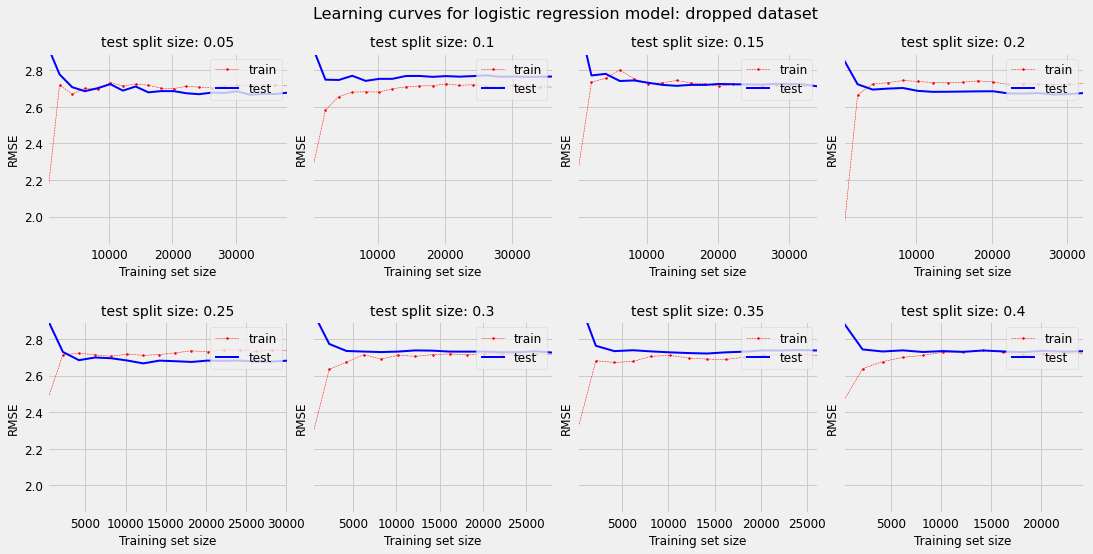

In [59]:
plot_learning_curves(logreg_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for logistic regression model: dropped dataset', plot_name='logreg_dropped', scale=2000, start_size = 200)

# plot_learning_curve(logreg_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for logistic regression model: dropped dataset', plot_name='logreg_dropped')

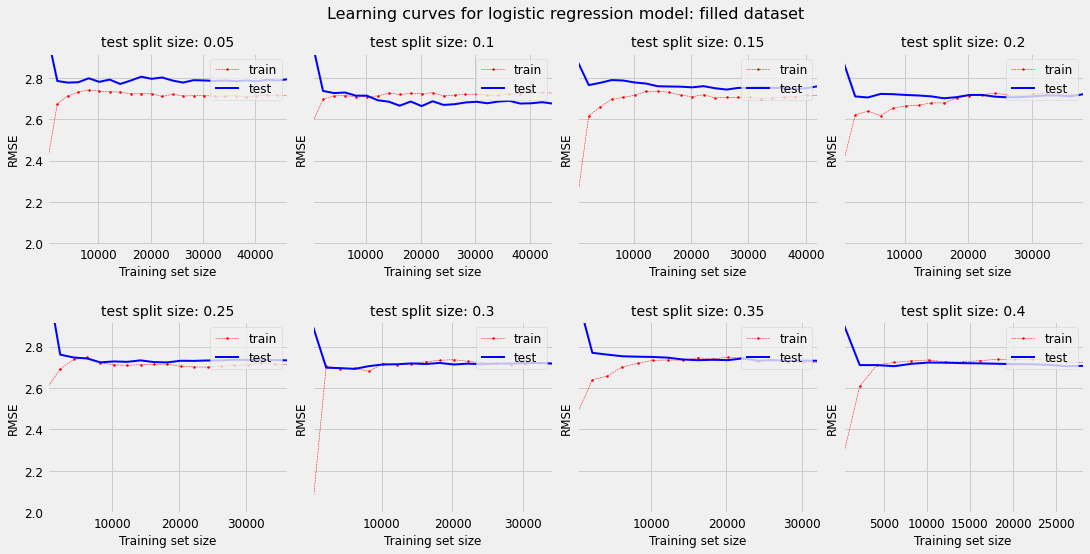

In [60]:
plot_learning_curves(logreg_filled, X_filled, y_filled_nums,
                     'Learning curves for logistic regression model: filled dataset', plot_name='logreg_filled', scale=2000, start_size=200)

# plot_learning_curve(logreg_filled, X_filled, y_filled_nums,
#                      'Learning curves for logistic regression model: filled dataset', plot_name='logreg_filled')

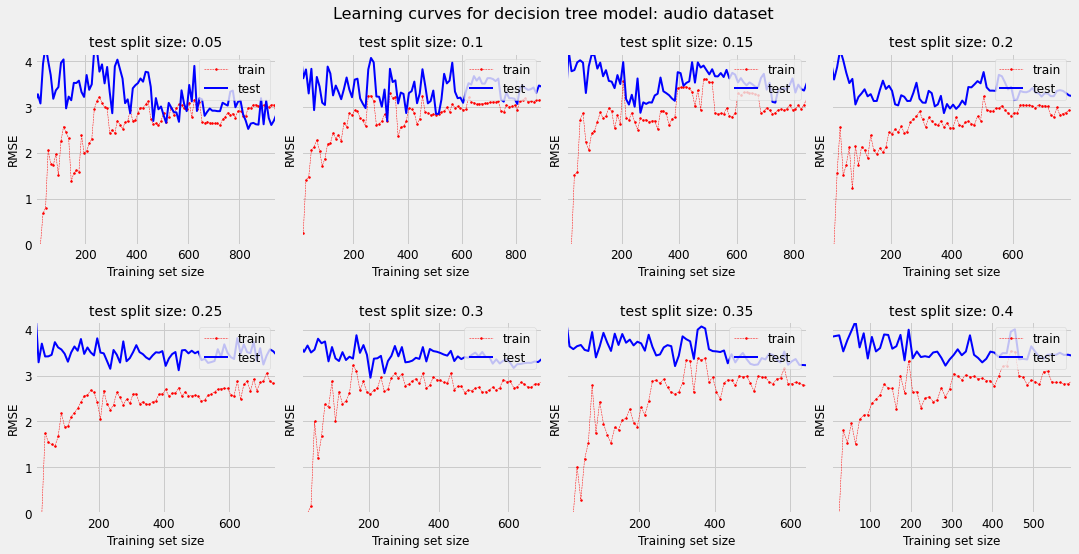

In [61]:
plot_learning_curves(tree_audio, X_audio, y_audio_nums,
                     'Learning curves for decision tree model: audio dataset', plot_name='tree_audio')

# plot_learning_curve(tree_audio, X_audio, y_audio_nums,
#                      'Learning curves for decision tree model: audio dataset', plot_name='tree_audio', splits = 30)


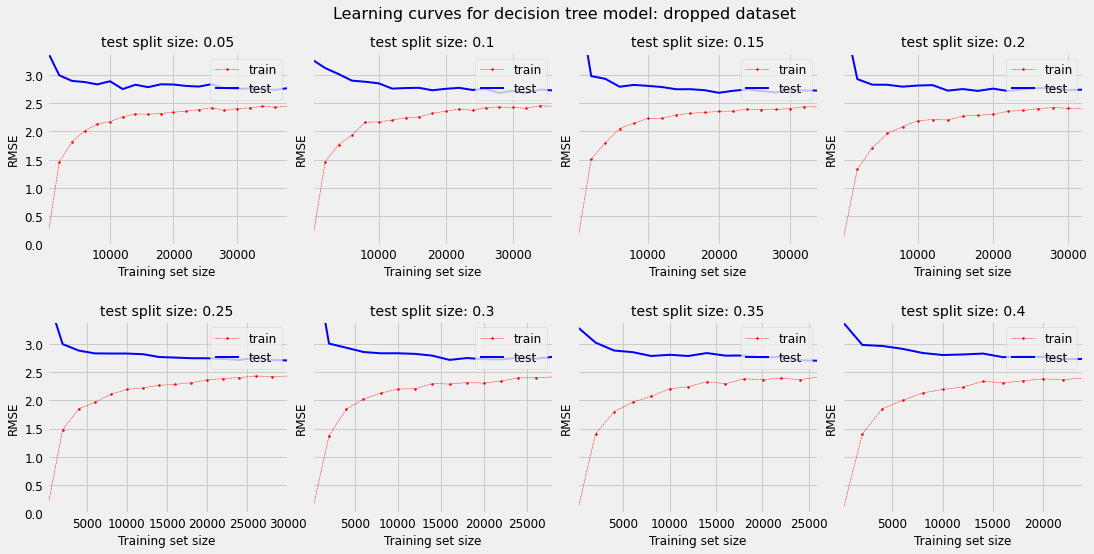

In [62]:
plot_learning_curves(tree_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for decision tree model: dropped dataset', plot_name='tree_dropped', scale=2000)

# plot_learning_curve(tree_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for decision tree model: dropped dataset', plot_name='tree_dropped')


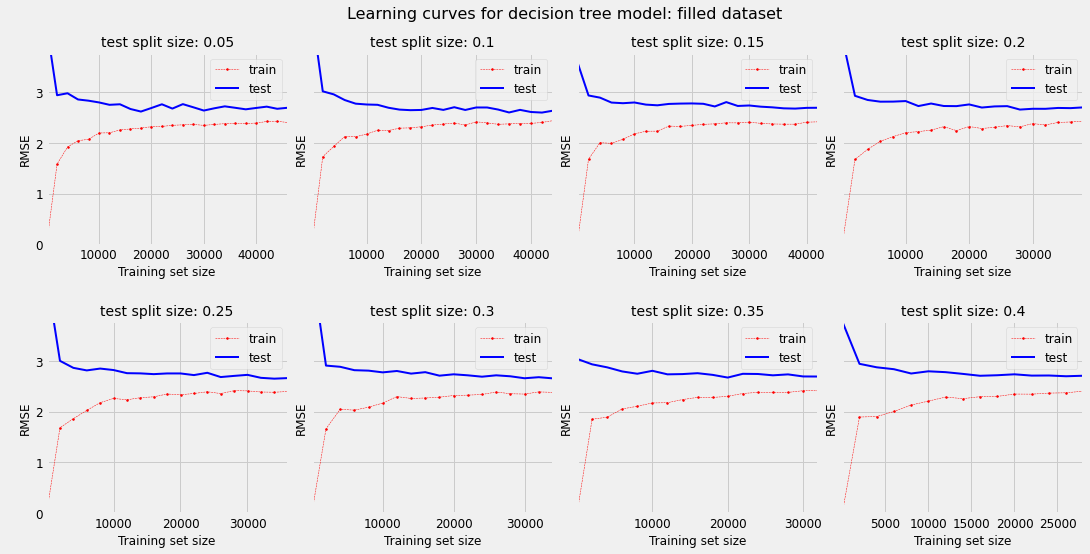

In [63]:
plot_learning_curves(tree_filled, X_filled, y_filled_nums,
                     'Learning curves for decision tree model: filled dataset', plot_name='tree_filled', scale=2000)

# plot_learning_curve(tree_filled, X_filled, y_filled_nums,
#                      'Learning curves for decision tree model: filled dataset', plot_name='tree_filled')


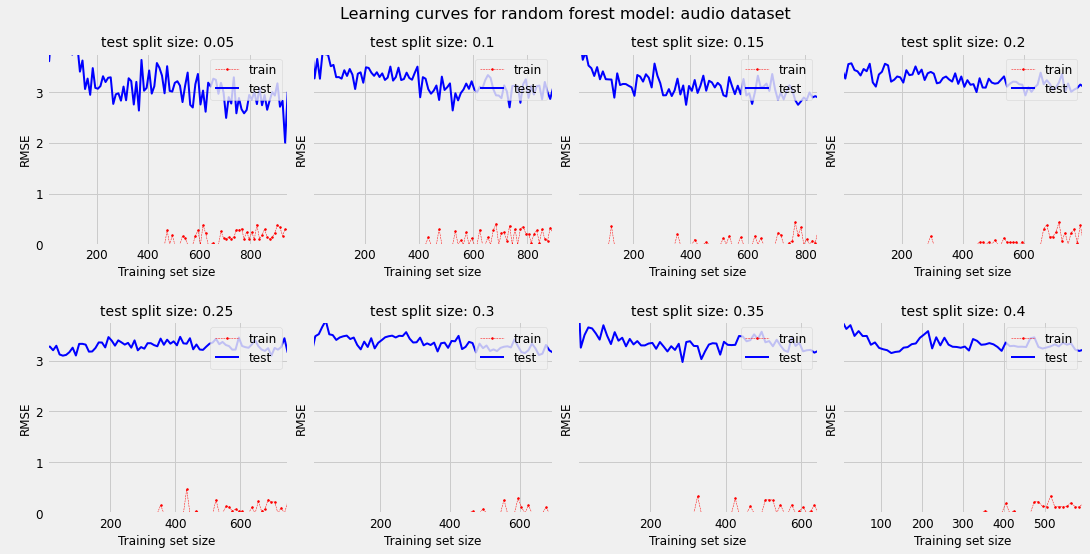

In [64]:
plot_learning_curves(forest_audio, X_audio, y_audio_nums,
                     'Learning curves for random forest model: audio dataset', plot_name='forest_audio')

# plot_learning_curve(forest_audio, X_audio, y_audio_nums,
#                     'Learning curves for random forest model: audio dataset', plot_name='forest_audio', splits=20)


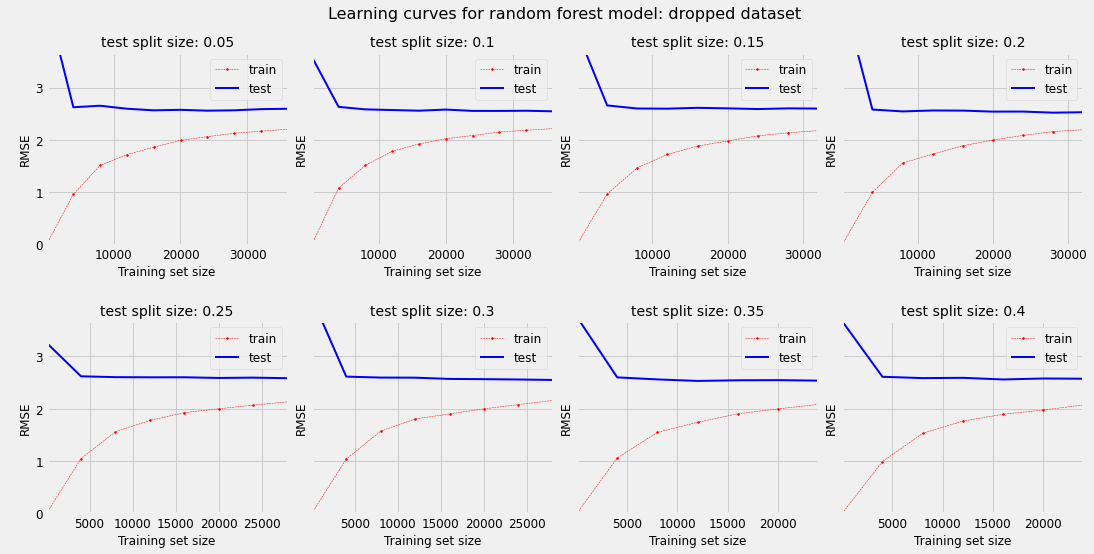

In [65]:
plot_learning_curves(forest_dropped, X_dropped, y_dropped_nums,
                     'Learning curves for random forest model: dropped dataset', plot_name='forest_dropped', scale=4000)

# plot_learning_curve(forest_dropped, X_dropped, y_dropped_nums,
#                      'Learning curves for random forest model: dropped dataset', plot_name = 'forest_dropped')


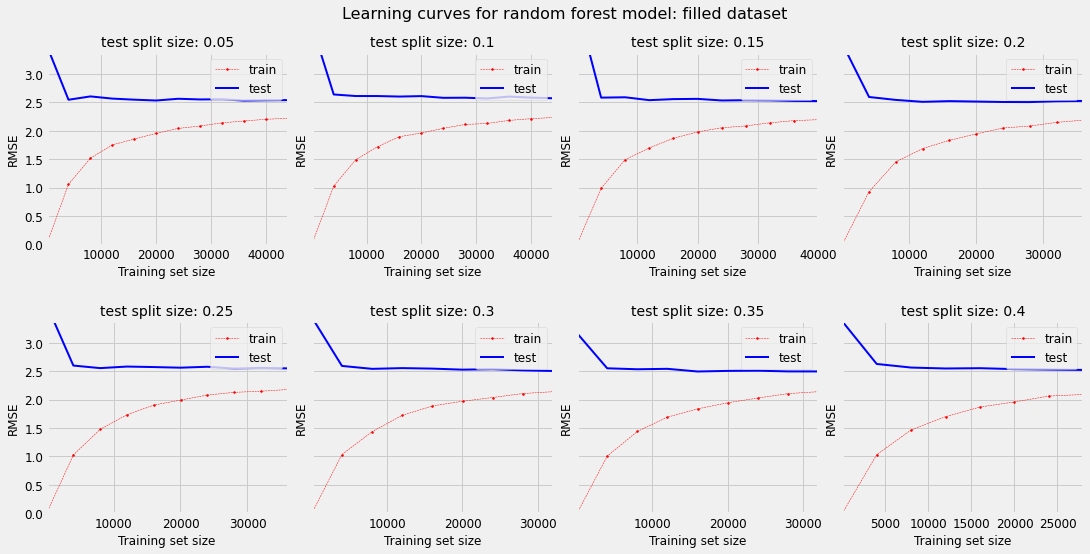

In [66]:
plot_learning_curves(forest_filled, X_filled, y_filled_nums,
                     'Learning curves for random forest model: filled dataset', plot_name='forest_filled', scale=4000)

# plot_learning_curve(forest_filled, X_filled, y_filled_nums,
#                      'Learning curves for random forest model: filled dataset', plot_name='forest_filled')
